In [96]:
import pandas as pd
import numpy as np
%matplotlib inline

In [30]:
# Fairness metrics
def CohenD(yobs, ypred, gmaj, gmin):
    ### Cohen-D
    SR_min = ypred[gmin==1].mean() # success rate minority
    SR_maj = ypred[gmaj==1].mean() # success rate majority
    
    STD_maj = np.sqrt(SR_maj * (1.0 - SR_maj))
    STD_min = np.sqrt(SR_min * (1.0 - SR_min))
    POOL_STD = STD_maj * ( sum(gmaj==1)/(sum(gmin==1) + sum(gmaj==1)) ) + STD_min * ( sum(gmin==1)/(sum(gmin==1) + sum(gmaj==1)) )
    
    return StatParity(yobs, ypred, gmaj, gmin)/POOL_STD

def DispImpact(yobs, ypred, gmaj, gmin):
    ### Disparate Impact (a.k.a. Adverse Impact Ratio)
    SR_min = ypred[gmin==1].mean() # success rate minority
    SR_maj = ypred[gmaj==1].mean() # success rate majority
    return SR_min/SR_maj

def StatParity(yobs, ypred, gmaj, gmin):
    ### Statistical Parity Difference
    SR_min = ypred[gmin==1].mean() # success rate minority
    SR_maj = ypred[gmaj==1].mean() # success rate majority
    return SR_min - SR_maj

def TwoSDRule(yobs, ypred, gmaj, gmin):
    ### 2-SD Rule
    SR_min = ypred[gmin==1].mean() # success rate minority
    SR_maj = ypred[gmaj==1].mean() # success rate majority
    SR_T = ypred.mean() # success rate total
    P_min = (gmin==1).mean() # minority proportion
    N = len(ypred)
    return (SR_min - SR_maj)/np.sqrt( (SR_T * (1.0 - SR_T))/(N * P_min * (1 - P_min)) )

def EqualOppDiff(yobs, ypred, gmaj, gmin):
    ### Equal Opportunity Difference
    TPR_maj = sum( (yobs[gmaj==1]==1) * (ypred[gmaj==1]==1) )/sum(yobs[gmaj==1]==1)
    TPR_min = sum( (yobs[gmin==1]==1) * (ypred[gmin==1]==1) )/sum(yobs[gmin==1]==1)
    return TPR_min - TPR_maj

def AvgOddsDiff(yobs, ypred, gmaj, gmin):
    ### Average Odds Difference
    return (EqualOppDiff(yobs==0, ypred==0, gmaj, gmin) + EqualOppDiff(yobs, ypred, gmaj, gmin))/2.0


def compute_model_metrics(yobs, model, Xobs, gmaj=None, gmin=None):
    # metrics
    from sklearn import metrics
    perf_metrics = {"Accuracy": metrics.accuracy_score, 
                    "Precision": metrics.precision_score, 
                    "Recall": metrics.recall_score,
                    "AUC": metrics.roc_auc_score, 
                    "F1-Score": metrics.f1_score, 
                    "Brier": metrics.brier_score_loss
                   }
    # fairness metrics
    fair_metrics = {"Cohen-D": CohenD,
                    "2-SD Rule": TwoSDRule,
                    "StatParity": StatParity,
                    "EqualOppDiff": EqualOppDiff,
                    "DispImpact": DispImpact,
                    "AvgOddsDiff": AvgOddsDiff
                   }
    
    # get predictions -- where you would start, after loading the data and model
    ypred_prob = model.predict_proba(Xobs).ravel()[1::2] # get probabilities
    ypred_class = model.predict(Xobs)
    
    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf in ["AUC", "Brier"]:
            metrics += [[pf, perf_metrics[pf](yobs, ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](yobs, ypred_class)]]
            
    if (gmaj is not None) and (gmin is not None):
        for ff in fair_metrics.keys():
            metrics += [[ff, fair_metrics[ff](yobs, ypred_class, gmaj, gmin)]]
    
    return pd.DataFrame(metrics, columns=["Metric", "Value"])

In [102]:
df = pd.read_pickle("mortgage_data_balanced.pkl.gz")
df = df.sample(n=20000)

In [103]:
keep_vars = ['respondent_id', 'as_of_year', 'agency_abbr', 'loan_type_name', 'loan_amount_000s', 'owner_occupancy_name',
             'loan_purpose_name', 'property_type_name', 'preapproval_name', 'msamd_name', 'state_abbr', 'county_name',
             'applicant_ethnicity_name', 'co_applicant_ethnicity_name', 'applicant_race_name_1', 'co_applicant_race_name_1',
             'applicant_sex_name', 'co_applicant_sex_name', 'applicant_income_000s', 'purchaser_type_name', 
             'denial_reason_name_1', 'hoepa_status_name', 'lien_status_name', 'population', 'minority_population',
             'hud_median_family_income', 'tract_to_msamd_income', 'number_of_owner_occupied_units', 
             'number_of_1_to_4_family_units', 'action_taken_name']

df = df[keep_vars].copy()

In [104]:
df['action_taken_name'].value_counts()

Loan originated                                10025
Application denied by financial institution     9975
Name: action_taken_name, dtype: int64

In [105]:
# categorical variables
cat_variables = cat_variables = ['applicant_ethnicity_name', 'applicant_race_name_1', 'applicant_sex_name', 'agency_abbr',
                                 'owner_occupancy_name', 'property_type_name', 'loan_purpose_name', 'loan_type_name']

# other integer variables
int_variables = ['loan_amount_000s', 'applicant_income_000s', 'population', 'minority_population', 
                 'hud_median_family_income', 'tract_to_msamd_income', 'number_of_owner_occupied_units', 
                 'number_of_1_to_4_family_units']

# target variable
output_variable = ['action_taken_name']

### Pre-processing
# Mapping categorical variables to one-hot encoding
df_cat = pd.DataFrame(index=df.index)

# one-hot encoding of categorical variables
from sklearn.preprocessing import OneHotEncoder

# I will do a loop for pedagogical reasons, but it is not entirely necessary
for cat in cat_variables:
    # one-hot encoding fitting
    one_hot_func = OneHotEncoder().fit(df[[cat]])
    
    # mapping
    cat_mapped = one_hot_func.transform(df[[cat]]).toarray()
    
    # storing
    for (k, cat_label) in enumerate(one_hot_func.categories_[0]):
        df_cat[cat + "_" + cat_label] = cat_mapped[:, k]

# consolidating a final dataset
X = pd.concat([df[int_variables], df_cat], axis=1)
y = (df[output_variable] == "Application denied by financial institution").copy()

# removing race, ethnicity, sex and minority population from X
X_ub = X[[
    'loan_amount_000s', 'applicant_income_000s', 'population', 'hud_median_family_income', 'tract_to_msamd_income', 
    'number_of_owner_occupied_units', 'number_of_1_to_4_family_units', 'agency_abbr_CFPB', 'agency_abbr_FDIC',
       'agency_abbr_FRS', 'agency_abbr_HUD', 'agency_abbr_NCUA',
       'agency_abbr_OCC', 'owner_occupancy_name_Not applicable',
       'owner_occupancy_name_Not owner-occupied as a principal dwelling',
       'owner_occupancy_name_Owner-occupied as a principal dwelling',
       'property_type_name_Manufactured housing',
       'property_type_name_One-to-four family dwelling (other than manufactured housing)',
       'loan_purpose_name_Home improvement', 'loan_purpose_name_Home purchase',
       'loan_purpose_name_Refinancing', 'loan_type_name_Conventional',
       'loan_type_name_FHA-insured', 'loan_type_name_FSA/RHS-guaranteed',
       'loan_type_name_VA-guaranteed'
]].copy()

# protected attributtes
X_groups = X[[
    'minority_population', 'applicant_ethnicity_name_Hispanic or Latino',
       'applicant_ethnicity_name_Not Hispanic or Latino',
       'applicant_race_name_1_American Indian or Alaska Native',
       'applicant_race_name_1_Asian',
       'applicant_race_name_1_Black or African American',
       'applicant_race_name_1_Native Hawaiian or Other Pacific Islander',
       'applicant_race_name_1_White', 'applicant_sex_name_Female',
       'applicant_sex_name_Male'
]].copy()


In [106]:
X.describe()

,loan_amount_000s,applicant_income_000s,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,applicant_ethnicity_name_Hispanic or Latino,applicant_ethnicity_name_Not Hispanic or Latino,...,owner_occupancy_name_Owner-occupied as a principal dwelling,property_type_name_Manufactured housing,property_type_name_One-to-four family dwelling (other than manufactured housing),loan_purpose_name_Home improvement,loan_purpose_name_Home purchase,loan_purpose_name_Refinancing,loan_type_name_Conventional,loan_type_name_FHA-insured,loan_type_name_FSA/RHS-guaranteed,loan_type_name_VA-guaranteed
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,190.753750,103.349800,5794.039800,21.432511,69549.65500,116.942927,1620.309400,2070.980150,0.062850,0.937150,...,0.893350,0.031650,0.968350,0.071050,0.287300,0.641650,0.799550,0.150200,0.014800,0.035450
std,176.404345,145.341028,2979.961249,22.073696,13793.52598,38.658755,924.327899,1122.732341,0.242699,0.242699,...,0.308675,0.175071,0.175071,0.256915,0.452514,0.479528,0.400347,0.357276,0.120755,0.184919
min,1.000000,1.000000,96.000000,0.580000,16300.00000,18.290001,5.000000,7.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.000000,46.000000,3846.750000,5.940000,60600.00000,92.510002,1027.000000,1355.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,150.000000,74.000000,5208.000000,13.230000,67400.00000,110.000000,1452.000000,1834.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,245.000000,119.000000,6993.000000,28.170000,78200.00000,133.649994,2000.000000,2488.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,4500.000000,9999.000000,34055.000000,99.900002,111900.00000,430.029999,9880.000000,10724.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [107]:
# set metrics
# performance metrics
gmaj = X[['applicant_sex_name_Male']]
gmin = X[['applicant_sex_name_Female']]

# train model
#from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.neural_network import MLPClassifier
#rf = RandomForestClassifier(n_estimators=10, random_state=10, class_weight="balanced")
#rf = MLPClassifier(random_state=10, solver="lbfgs")
rf = LogisticRegression(random_state=10, class_weight="balanced", solver="lbfgs")
rf = rf.fit(X, y.values.ravel())

# compute metrics
compute_model_metrics(y.values.ravel(), rf, X, gmaj.values.ravel(), gmin.values.ravel())

C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Metric,Value
0,Accuracy,0.552550
1,Precision,0.567696
2,Recall,0.431278
3,AUC,0.577541
4,F1-Score,0.490173
5,Brier,0.245727
6,Cohen-D,0.216382
7,2-SD Rule,13.818518
8,StatParity,0.104447
9,EqualOppDiff,0.098267


## Simple experiment

In [108]:
z = (X[['applicant_income_000s']] - X[['applicant_income_000s']].mean())/X[['applicant_income_000s']].std()

In [114]:
# pre-allocation
max_iters = 300
rf = LogisticRegression(random_state=10, class_weight="balanced", solver="lbfgs")
rf.fit(z.head(2), [0, 1])
df_results = pd.DataFrame(index=[0], columns=["a", "b", 'Accuracy', 'Precision', 'Recall', 'AUC', 'F1-Score',
                                             'Brier', 'Cohen-D', '2-SD Rule', 'StatParity', 'EqualOppDiff',
                                             'DispImpact', 'AvgOddsDiff'])

for k in range(max_iters):
    a, b = np.random.normal(), np.random.normal()
    rf.intercept_ = np.array([a])
    rf.coef_ = np.array([[b]])
    c = compute_model_metrics(y.values.ravel(), rf, z, gmaj.values.ravel(), gmin.values.ravel())
    df_results.loc[k] = [a, b] + c["Value"].values.tolist()
    print(k)

0
1


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


2
3
4
5


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


6


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


7
8
9
10


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


11
12
13
14
15
16
17


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


18


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


19
20


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


21
22


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


23


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


24
25
26
27


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


28
29
30
31
32
33
34
35


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


36
37
38
39
40


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


41


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


42


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


43


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


44
45
46
47
48
49
50


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


51
52
53
54


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


55
56
57


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


58
59
60
61
62


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


63


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


64


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


65
66
67
68


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


69


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


70
71
72
73
74
75
76


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


77
78
79
80


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


81
82
83
84
85
86


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


87
88


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


89


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


90
91


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


92


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


93
94
95
96
97
98
99
100
101


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


102
103
104
105
106
107
108
109


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


110


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


111
112
113
114
115
116
117
118


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


119


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


120
121


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


122
123
124


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


125
126
127
128
129
130


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


131


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


132
133


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


134


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


135
136
137


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


138
139


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


140


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


141
142
143
144
145


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


146
147
148
149


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


150
151
152
153


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


154
155
156
157
158
159


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


160
161


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


162
163
164


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


165
166


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


167
168


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


185
186


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


187
188
189
190


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


191
192
193
194
195
196
197
198
199


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


200


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


201
202


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


203
204
205
206
207
208
209
210


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


211


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


212
213
214
215
216
217


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


218


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


219
220


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


221


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


222
223
224


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


225
226
227
228


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


229
230
231
232
233


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


234


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


235
236
237
238
239
240


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


241
242
243


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


244
245


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


246


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


247


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


248
249
250
251
252
253
254
255
256


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


257
258


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


259
260


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


261
262


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


263


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


264
265
266
267
268


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


269
270


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


271
272
273
274
275
276
277
278
279
280
281


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


282
283
284
285
286


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


287


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


288
289
290
291


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


292
293
294
295


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


296


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


297


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


298


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


299


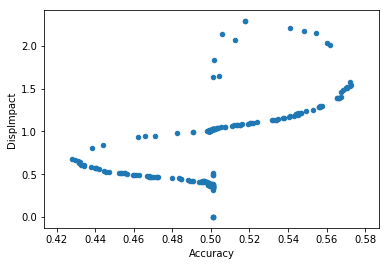

In [115]:
df_results.dropna().astype(float).plot(x = 'Accuracy', y = 'DispImpact', kind='scatter')

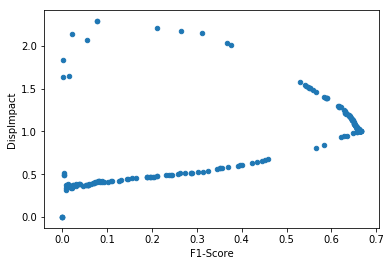

In [116]:
df_results.dropna().astype(float).plot(x = 'F1-Score', y = 'DispImpact', kind='scatter')

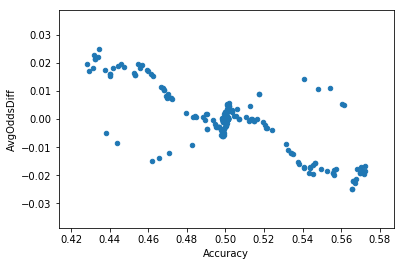

In [119]:
df_results.dropna().astype(float).plot(x = 'Accuracy', y = 'AvgOddsDiff', kind='scatter')

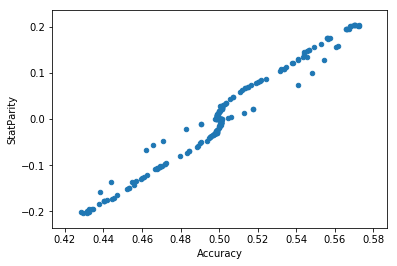

In [120]:
df_results.dropna().astype(float).plot(x = 'Accuracy', y = 'StatParity', kind='scatter')

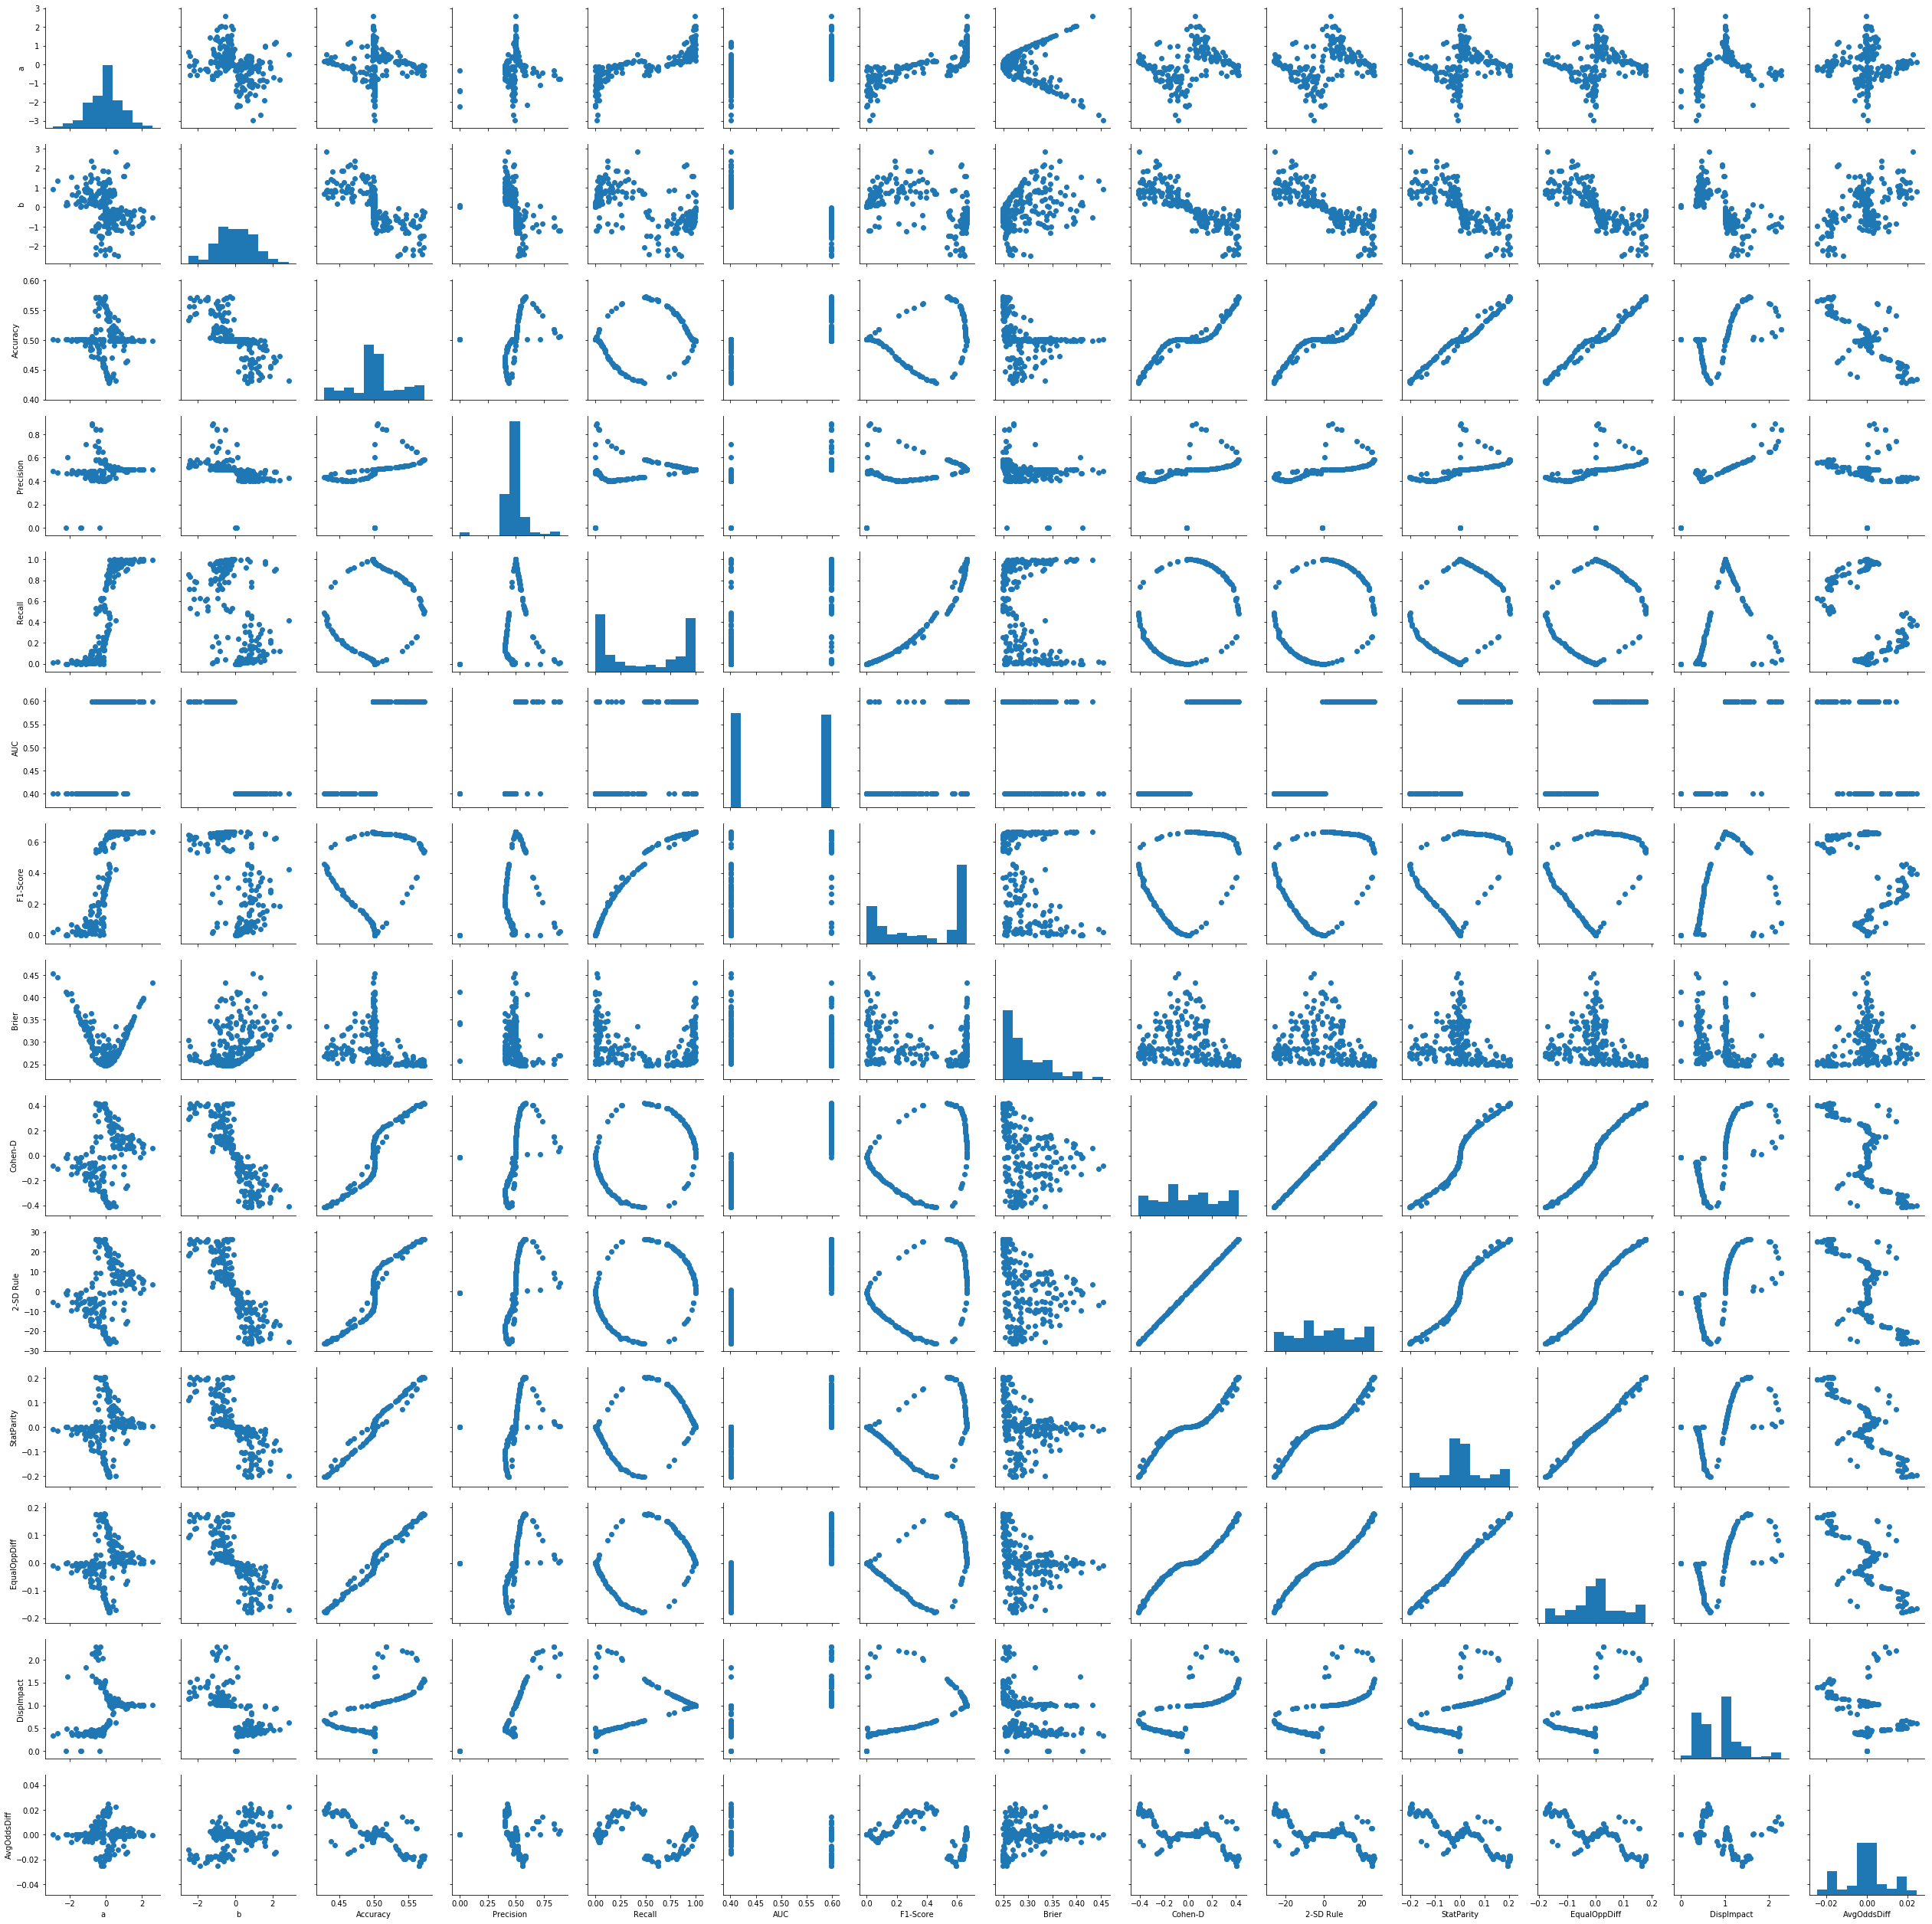

In [117]:
from matplotlib import pyplot as plt
import seaborn as sns
g = sns.PairGrid(df_results.dropna().astype(float))
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)